In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sympy import *
from tqdm.notebook import tqdm
import pickle

In [3]:
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

train_full = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_full = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [5]:
class BinaryData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data)
        self.y_data = torch.from_numpy(y_data).type(torch.LongTensor)
        self.len = len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [6]:
# Get indices of samples associated to filtered_classes
class_names = train_full.classes
filtered_classes = ['3 - three', '6 - six']
filtered_labels=[class_names.index(cl) for cl in filtered_classes]

train_data = {'x':[], 'y':[]}
for xdata, ydata in train_full:  
    if ydata in filtered_labels:
        train_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            train_data['y'].append(0)
        else:
            train_data['y'].append(1)
        
test_data = {'x':[], 'y':[]}
for xdata, ydata in test_full:  
    if ydata in filtered_labels:
        test_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            test_data['y'].append(0)
        else:
            test_data['y'].append(1)

In [7]:
train_dataset = BinaryData(np.array(train_data['x']), np.array(train_data['y']))
test_dataset = BinaryData(np.array(test_data['x']), np.array(test_data['y']))

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
# Temporal Dynamics
num_steps = 25
beta = 0.99

# Quantum Spike Neural Network

In [10]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [11]:
class QuantumCircuit_simulator:
    def __init__(self):
#         self._circuit = qiskit.QuantumCircuit(n_qubits)
        
#         all_qubits = [i for i in range(n_qubits)]
#         self.theta = qiskit.circuit.Parameter('theta')
        self.theta = symbols('theta')
        self.Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128).to(device)
        self.H = torch.tensor([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], dtype=torch.complex128).to(device)
        self.init_state = torch.tensor([1,0], dtype=torch.complex128).to(device)
        self.init_state = torch.matmul(self.H, self.init_state).reshape(-1,1).to(device)
#         self._circuit.h(all_qubits)
#         self._circuit.barrier()
#         self._circuit.ry(self.theta, all_qubits)
        
#         self._circuit.measure_all()

#         self.backend = backend
#         self.shots = shots
    
    def run(self, thetas):
        cosines = torch.cos(thetas/2)
        sines = torch.sin(thetas/2)
        Rys = [ torch.tensor([[c, -s], [s,c]], dtype=torch.complex128) for c, s in zip(cosines, sines) ]
        Rys = torch.stack(Rys, axis=0).to(device)
        
        out_states = torch.einsum("ikj, jl -> ikl", Rys, self.init_state)
        out_probs = (out_states**2).real.squeeze().float()
        
        states = torch.tensor([0., 1.]).to(device)
#         states = np.array(list(result.keys())).astype(float)
#         states = 2*(states - 0.5)
        # Compute probabilities for each state
#         probabilities = counts / self.shots
        # Get state expectation
        exps = torch.matmul(out_probs, states)
        
        return exps
    
    def get_grad(self, thetas):
        return torch.cos(thetas/2)**2 - torch.sin(thetas/2)**2

In [12]:
circuit_simulator = QuantumCircuit_simulator()
print('Expected value for rotation pi {}'.format(circuit_simulator.run(torch.ones(10))))
# circuit._circuit.draw('mpl')

Expected value for rotation pi tensor([0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207, 0.9207,
        0.9207])


In [13]:
class HybridFunction(torch.autograd.Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        result_exp = ctx.quantum_circuit.run(inputs)
        ctx.save_for_backward(inputs, result_exp)

        return result_exp
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        inputs, result_exp = ctx.saved_tensors
#         input_list = np.array(inputs.tolist())
        gradients = ctx.quantum_circuit.get_grad(inputs)
        
#         shift_right = inputs + torch.ones(inputs.shape) * ctx.shift
#         shift_left = inputs - np.ones(inputs.shape) * ctx.shift

#         expectation_right = ctx.quantum_circuit.run(shift_right)
#         expectation_left  = ctx.quantum_circuit.run(shift_left)
#         gradients = expectation_right - expectation_left
#         print((grad_output.float() ).shape)
        return (gradients.squeeze().float() * grad_output.float()).reshape(-1,1), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit_simulator()
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [14]:
# Define Network
class Hybrid_qsnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(28*28, 100)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(100, 10)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(10, 1)
        self.hybrid = Hybrid(np.pi / 2)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk = torch.stack(spk2_rec, dim=0).sum(axis=0)
        q_in = self.fc3(summed_spk)
        x1 = self.hybrid(q_in)
        x0 = 1 - x1
        out = torch.cat((x0.reshape(-1,1),x1.reshape(-1,1)), axis=1)
        return out

net_test = Hybrid_qsnn().to(device)

In [15]:
num_param = 0
for p in net_test.parameters():
    mul = 1
    for num in list(p.shape):
        mul *= num
    num_param += mul
print(num_param)

79521


In [16]:
def training(net, model='qsnn'):
    dataset_sizes = train_loader.dataset.len
    test_dataset_sizes = test_loader.dataset.len
        
    loss = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

    num_epochs = 10
    loss_hist = []
    test_loss_hist = []
    acc_hist = []
    test_acc_hist = []
    best_test_acc = 0

    # Outer training loop
    for epoch in tqdm(range(num_epochs), leave=False):
        train_batch = iter(train_loader)

        train_loss, test_loss = 0, 0
        train_acc, test_acc = 0, 0
        
        # Minibatch training loop
        for it, (data, targets) in tqdm(enumerate(train_batch),leave=False):
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            if model =='qsnn':
                preds = net(data.view(len(data), -1))
            elif model =='qcnn':
                preds = net(data)
    #         print(preds)
            # initialize the loss & sum over time
            loss_val = loss(preds, targets)
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if model =='qsnn':
                preds = net(data.view(len(data), -1))
            elif model =='qcnn':
                preds = net(data)
            _, idx =  preds.max(1)
            acc = np.sum((targets == idx).detach().cpu().numpy())
            train_acc += acc
            train_loss += loss_val.item() * len(data)

#         print(f"Epoch {epoch}, Iteration {it}")
#         print(f"Train Set Loss: {train_loss / dataset_sizes:.2f}")
#         print(f"Train set accuracy: {train_acc/dataset_sizes*100:.2f}%")

        # Test set
        with torch.no_grad():
            net.eval()
#             test_batch = iter(test_loader)
#             for it, (test_data, test_targets) in tqdm(enumerate(test_batch),leave=False):
            test_data_full = test_loader.dataset[:]
            test_data = test_data_full[0].to(device)
            test_targets = test_data_full[1].to(device)

            # Test set forward pass
            if model =='qsnn':
                test_preds = net(test_data.view(len(test_data), -1))
            elif model =='qcnn':
                test_preds = net(test_data)

            test_loss += loss(test_preds, test_targets).item() * len(test_data)
            preds = []
            for p in test_preds:
                if p[0] > p[1]:
                    preds.append(0)
                else:
                    preds.append(1)
            test_acc = float(torch.sum(torch.tensor(preds) == test_targets))
            
#             print(f"Test Set Loss: {test_loss / test_loader.dataset.len:.2f}")
#             print(f"Test set accuracy: {test_acc/test_loader.dataset.len*100:.2f}%")

        # Store loss history for future plotting
        loss_hist.append(train_loss / dataset_sizes)
        test_loss_hist.append(test_loss / test_dataset_sizes)

        acc_hist.append(train_acc / dataset_sizes)
        test_acc_hist.append(test_acc / test_dataset_sizes)
        
        if test_acc_hist[-1] > best_test_acc:
            best_test_acc = test_acc_hist[-1]
            best_model_state = net.state_dict()
            print('best model updated / Acc: ', best_test_acc)
    
    return loss_hist.copy(), test_loss_hist.copy(), acc_hist.copy(), test_acc_hist.copy(), best_model_state

In [ ]:
# data_dict = {}
# data_dict['train_loss'], data_dict['test_loss'] = [], []
# data_dict['train_acc'], data_dict['test_acc'] = [], []
# data_dict['best_model'] = []
# for i in tqdm(range(10)):
#     net = Hybrid_qsnn().to(device)
#     lh, tlh, ah, tah, bm = training(net, model='qsnn')
#     data_dict['train_loss'].append(lh)
#     data_dict['test_loss'].append(tlh)
#     data_dict['train_acc'].append(ah)
#     data_dict['test_acc'].append(tah)
#     data_dict['best_model'].append(bm)

In [ ]:
# import pickle

# with open('QSNN.pkl', 'wb') as f:
#     pickle.dump(data_dict, f)

# Quantum Convoulutional Neural Network

In [17]:
# Define Network
class Hybrid_qcnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=5, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 5, out_channels=15, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(24*24*15, 10)
        self.fc2 = nn.Linear(10, 1)
        self.hybrid = Hybrid(np.pi / 2)

    def forward(self, x):
        lendata = len(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(lendata, -1)
        x = F.relu(self.fc1(x))
        q_in = self.fc2(x)        
        x1 = self.hybrid(q_in)
#         x = [self.hybrid(summed_spk[i]) for i in range(len(summed_spk))]
#         x1 = torch.cat(x)
        x0 = 1 - x1
        out = torch.cat((x0.reshape(-1,1),x1.reshape(-1,1)), axis=1)
        return out

net_test = Hybrid_qcnn().to(device)

In [18]:
num_param = 0
for p in net_test.parameters():
    mul = 1
    for num in list(p.shape):
        mul *= num
    num_param += mul
print(num_param)

87161


In [ ]:
# data_dict = {}
# data_dict['train_loss'], data_dict['test_loss'] = [], []
# data_dict['train_acc'], data_dict['test_acc'] = [], []
# data_dict['best_model'] = []
# for i in tqdm(range(10)):
#     net = Hybrid_qcnn().to(device)
#     lh, tlh, ah, tah, bm = training(net, model='qcnn')
#     data_dict['train_loss'].append(lh)
#     data_dict['test_loss'].append(tlh)
#     data_dict['train_acc'].append(ah)
#     data_dict['test_acc'].append(tah)
#     data_dict['best_model'].append(bm)

In [ ]:
# import pickle

# with open('QCNN.pkl', 'wb') as f:
#     pickle.dump(data_dict, f)

In [19]:
import pickle
with open('QSNN.pkl', 'rb') as f:
    qsnn_data = pickle.load(f)
with open('QCNN.pkl', 'rb') as f:
    qcnn_data = pickle.load(f)
datas = {}
datas['qsnn'] = qsnn_data
datas['qcnn'] = qcnn_data
colors = {'qsnn':'red', 'qcnn':'green'}

In [20]:
qsnn_data.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc', 'best_model'])

In [21]:
def plotter(title, plot_type, ylabel):
    for k in datas.keys():
        mu = np.array(datas[k][plot_type]).mean(axis=0)
        plt.plot(range(10), mu, c=colors[k], label=k)
        std = np.array(datas[k][plot_type]).std(axis=0)
        plt.fill_between(range(10),mu-std, mu+std, color=colors[k], alpha=0.2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

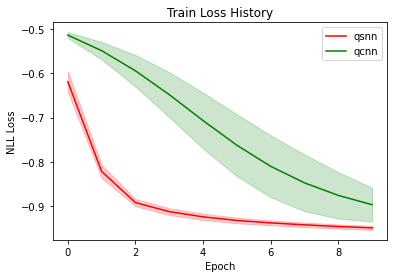

In [22]:
plotter('Train Loss History', 'train_loss', 'NLL Loss')

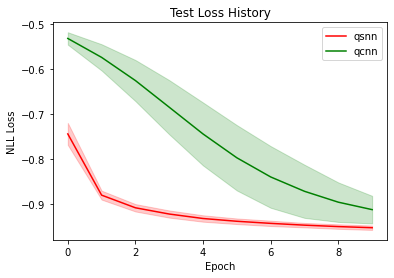

In [23]:
plotter('Test Loss History', 'test_loss', 'NLL Loss')

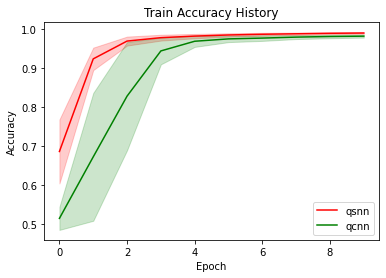

In [24]:
plotter('Train Accuracy History', 'train_acc', 'Accuracy')

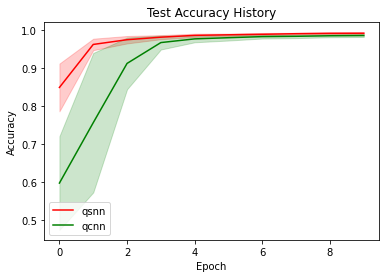

In [25]:
plotter('Test Accuracy History', 'test_acc', 'Accuracy')

# QSNN on Real Quantum Device

In [26]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
ibm_token = '49670f985b02b984d52967234a8d86aa4f49519731f6a3b1b9b5c2afffde9d8f34d46e6df77cf8ec96e1adf36aadeaf8a6c4a73665cfb2945627ed954451f473' # https://quantum-computing.ibm.com/account
ibmq_account = IBMQ.enable_account(ibm_token)
ibmq_provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-graduate')
# ibmq_backend = ibmq_provider.get_backend('ibm_perth')

In [47]:
ibmq_backend = ibmq_provider.get_backend('ibmq_mumbai')

In [27]:
from qiskit_ionq import IonQProvider
ionq_provider = IonQProvider('6fQ3841QgvhddNsUsf6PYdqRdBZjgRDL')
ionq_backend = ionq_provider.get_backend('ionq_qpu')

In [28]:
simulator = qiskit.Aer.get_backend('aer_simulator')

In [29]:
print([max(d) for d in datas['qsnn']['test_acc']])

[tensor(0.9964), tensor(0.9939), tensor(0.9929), tensor(0.9949), tensor(0.9954), tensor(0.9914), tensor(0.9888), tensor(0.9909), tensor(0.9959), tensor(0.9903)]


In [30]:
print([max(d) for d in datas['qcnn']['test_acc']])

[tensor(0.9863), tensor(0.9878), tensor(0.9878), tensor(0.9924), tensor(0.9832), tensor(0.9782), tensor(0.9909), tensor(0.9893), tensor(0.9837), tensor(0.9893)]


In [31]:
best_statedict = datas['qsnn']['best_model'][0]

In [60]:
class QuantumCircuit:
    def __init__(self, backend, n_qubits=1, shots=10):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        thetas = thetas.tolist()
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots,
                        parameter_binds = [{self.theta: theta[0]} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        for r in result:
            if '0' not in r.keys():
                r['0'] = 0
            elif '1' not in r.keys():
                r['1'] = 0
            
        return result

In [77]:
# Define Network
class Hybrid_qsnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(28*28, 100)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(100, 10)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(10, 1)
        self.qc = QuantumCircuit(ibmq_backend)
#         self.qc = QuantumCircuit(ionq_backend)
#         self.qc = QuantumCircuit(simulator)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk = torch.stack(spk2_rec, dim=0).sum(axis=0)
        q_in = self.fc3(summed_spk)
        out = self.qc.run(q_in)
        return out
    
    def get_spikes(self, x):
            # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk1 = torch.stack(spk1_rec, dim=0).sum(axis=0)
        summed_spk2 = torch.stack(spk2_rec, dim=0).sum(axis=0)
        return summed_spk1, summed_spk2

In [78]:
model = Hybrid_qsnn().to(device)
model.load_state_dict(best_statedict)
model.eval()

Hybrid_qsnn(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [79]:
full_data_train = train_loader.dataset[:][0]
spike_data1, spike_data2 = model.get_spikes(full_data_train.view(len(full_data_train),-1))

In [83]:
spike_data1.mean(axis=0).detach().numpy()

array([4.77632999e-01, 2.69466352e+00, 3.22109723e+00, 3.28516889e+00,
       7.14349747e+00, 2.77035445e-01, 3.11436629e+00, 1.35438621e+00,
       3.11146164e+00, 3.04415298e+00, 1.07029629e+00, 3.26890206e+00,
       6.35662699e+00, 3.14250135e+00, 3.64445186e+00, 1.34782970e-01,
       1.41563618e+00, 4.59482098e+00, 9.23255062e+00, 5.32152033e+00,
       6.08548450e+00, 6.82795227e-01, 5.42808533e+00, 7.48103571e+00,
       6.30093813e-01, 1.31131215e-02, 4.05817890e+00, 4.69491243e+00,
       3.35654402e+00, 5.43870878e+00, 1.42982817e+00, 1.90654826e+00,
       9.30799198e+00, 3.02099753e-02, 3.60063076e+00, 9.08847237e+00,
       5.18756723e+00, 2.49780059e+00, 2.01842475e+00, 2.22308898e+00,
       1.22914761e-01, 3.00522876e+00, 1.27230477e+00, 3.31164408e+00,
       1.28765869e+00, 2.13403606e+00, 3.40692163e-01, 1.95534897e+00,
       4.24267578e+00, 3.51257372e+00, 5.57523441e+00, 2.08888698e+00,
       5.16258621e+00, 6.99302864e+00, 2.80637407e+00, 1.06515062e+00,
      

In [84]:
spike_data2.mean(axis=0).detach().numpy()

array([3.7596483e-02, 3.2349572e+00, 1.5768943e-03, 9.7850442e-02,
       2.4529006e+00, 3.4027721e-03, 9.9012367e-02, 2.4524857e-01,
       6.6202173e+00, 6.1415886e-03], dtype=float32)

In [ ]:
test_batch = iter(test_loader)
pred_data, input_data, target_data = [], [], []
for it, (test_data, test_targets) in tqdm(enumerate(test_batch),leave=False):
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)
    for i in range(len(test_data)):
        input_data.append(test_data.tolist()[i])
        target_data.append(test_targets.tolist()[i])
    
    test_preds = model(test_data.view(len(test_data), -1))
    for p in test_preds:
        pred_data.append(p)

In [ ]:
# ibmq_data = {'pred': pred_data, 'target': target_data, 'inputs': input_data, 'device': 'ibmq_kolkata'}
# with open('IBMQ_data_10shots.pkl', 'wb') as f:
#     pickle.dump(ibmq_data, f)

In [35]:
# with open('IBMQ_data_10shots.pkl', 'rb') as f:
#     pickle.load(f)

In [37]:
# preds = []
# for p in ibmq_data['pred']:
#     if p['0'] > p['1']:
#         preds.append(0)
#     else:
#         preds.append(1)

In [39]:
# np.sum(np.array(preds) == np.array(ibmq_data['target'])) / len(preds)

# QSNN with QEC

In [91]:
class QuantumCircuit_QEC:
    def __init__(self, backend, n_qubits=5, shots=128):
        self.theta = qiskit.circuit.Parameter('theta')
        
        # First 5 qubits : Logical qubits
        all_qubits = [i for i in range(n_qubits)]
        # Last 4 qubits : Syndrome qubits
        aux_qubits = [i for i in range(n_qubits, n_qubits+4)]
        qr = qiskit.QuantumRegister(n_qubits + 4)
        self._circuit = qiskit.QuantumCircuit(qr)
        self._circuit.h(0)
        self._circuit.s(0)
        self._circuit.cz(0,1)
        self._circuit.cz(0,3)
        self._circuit.cy(0,4)
        self._circuit.barrier()
        self._circuit.h(1)
        self._circuit.cz(1,2)
        self._circuit.cz(1,3)
        self._circuit.cnot(1,4)
        self._circuit.h(2)
        self._circuit.cz(2,0)
        self._circuit.cz(2,1)
        self._circuit.cnot(2,4)
        self._circuit.h(3)
        self._circuit.s(3)
        self._circuit.cz(3,0)
        self._circuit.cz(3,2)
        self._circuit.cy(3,4)
        # Decompose Ry using Rx, Rz
        self._circuit.barrier()
        self._circuit.rz(np.pi, all_qubits)
        self._circuit.rx(np.pi/2, all_qubits)
        self._circuit.rz(self.theta, all_qubits)
        self._circuit.rz(np.pi, all_qubits)
        self._circuit.rx(np.pi/2, all_qubits)
        # Decoding
        self._circuit.h(aux_qubits)
        self._circuit.barrier()
        self._circuit.cz(aux_qubits[0], 0)
        self._circuit.cx(aux_qubits[0], 1)
        self._circuit.cx(aux_qubits[0], 2)
        self._circuit.cz(aux_qubits[0], 3)
        self._circuit.barrier()
        self._circuit.cx(aux_qubits[1], 0)
        self._circuit.cx(aux_qubits[1], 1)
        self._circuit.cz(aux_qubits[1], 2)
        self._circuit.cz(aux_qubits[1], 4)
        self._circuit.barrier()
        self._circuit.cx(aux_qubits[2], 0)
        self._circuit.cz(aux_qubits[2], 1)
        self._circuit.cz(aux_qubits[2], 3)
        self._circuit.cx(aux_qubits[2], 4)
        self._circuit.barrier()
        self._circuit.cz(aux_qubits[3], 0)
        self._circuit.cz(aux_qubits[3], 2)
        self._circuit.cx(aux_qubits[3], 3)
        self._circuit.cx(aux_qubits[3], 4)
        self._circuit.barrier()
        self._circuit.h(aux_qubits)
        self._circuit.barrier()
        self._circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        thetas = thetas.tolist()
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots,
                        parameter_binds = [{self.theta: theta[0]} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
            
        return result

In [92]:
circuit = QuantumCircuit_QEC(ibmq_backend)

In [ ]:
# testdata = test_loader.dataset[:][0][0].view(1,1,28,28)
testdata = test_loader.dataset[:][0]
result = circuit.run(torch.tensor(testdata).view(len(testdata), -1))
result

<ipython-input-97-d189fcc866e1>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = circuit.run(torch.tensor(testdata).view(len(testdata), -1))


In [55]:
result

{'100011001': 1,
 '100110010': 1,
 '110101000': 1,
 '111110101': 1,
 '111111111': 1,
 '010000011': 1,
 '010110011': 1,
 '011000000': 1,
 '011111010': 1,
 '011111011': 1}

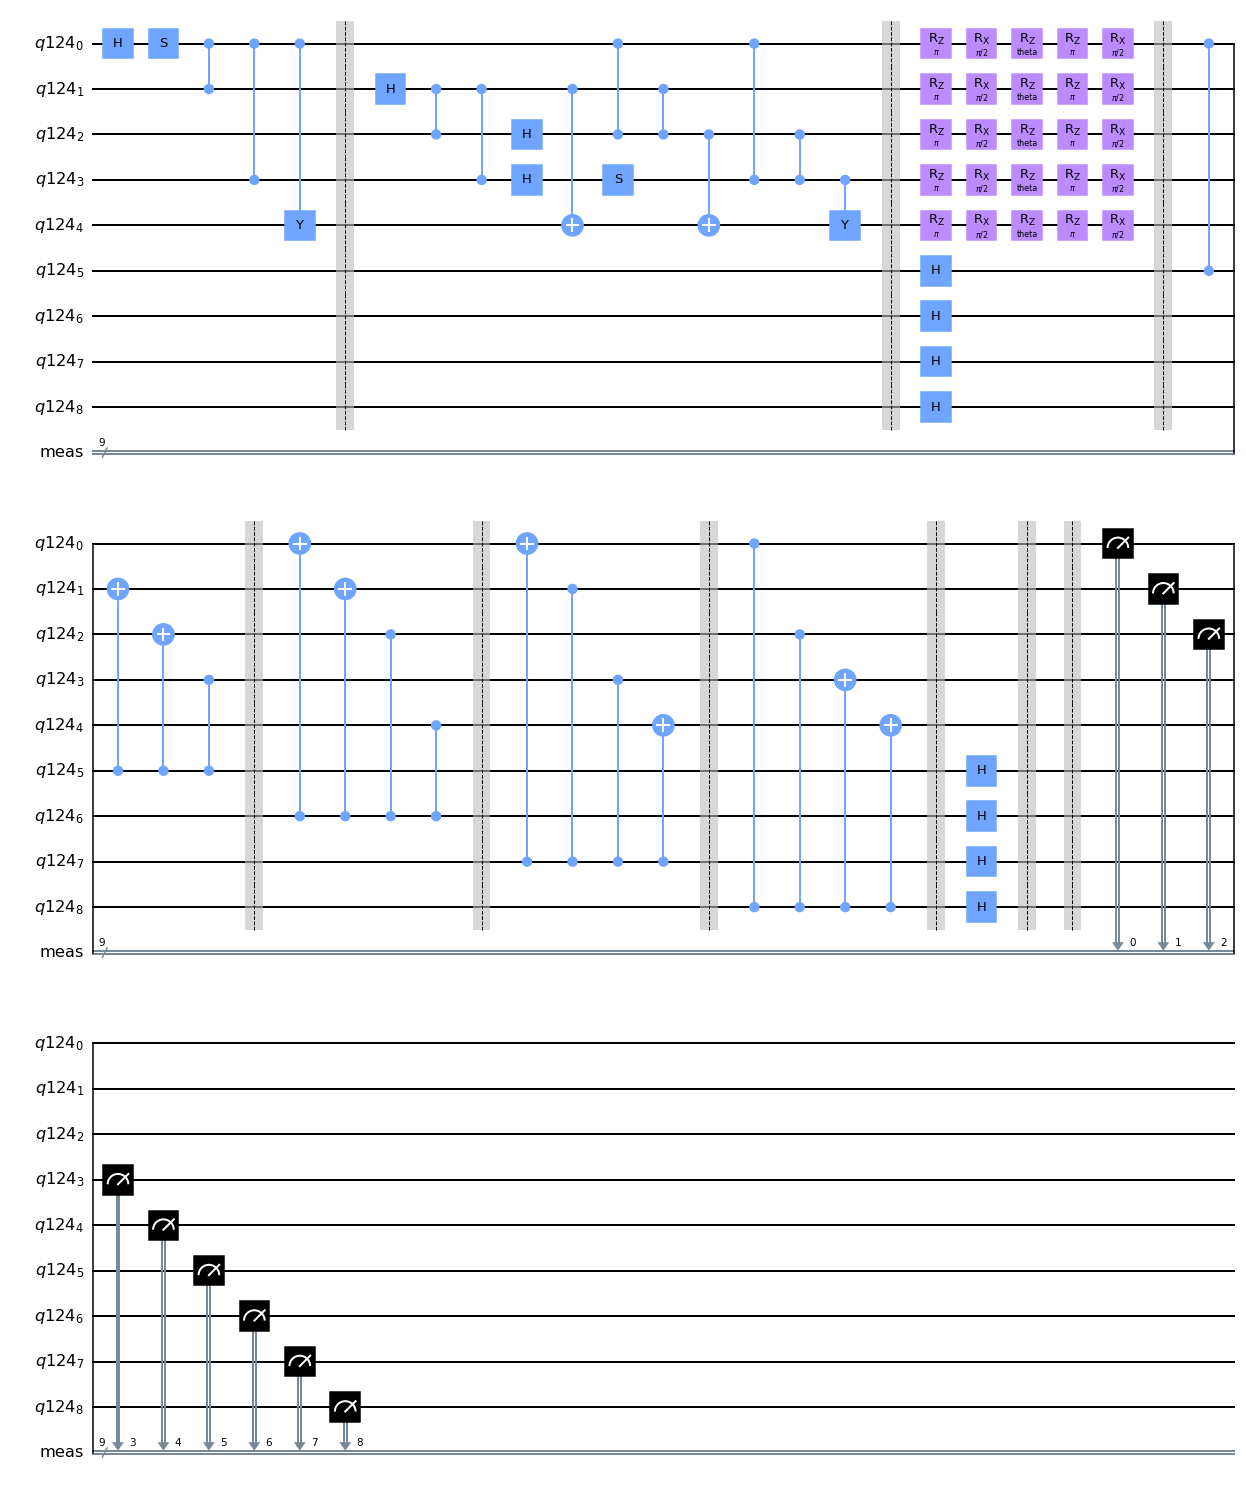

In [54]:
circuit._circuit.draw('mpl')

In [ ]:
# import qiskit.quantum_info as qi
# stv1 = qi.Statevector.from_instruction(circuit)
# stv1 = stv1.to_dict()
# stv1

In [ ]:
# keys = ['00000', '10010', '01001', '10100', '01010', '00101']
# dic_data = {}
# for k in keys:
#     dic_data[k] = 0.25
# keys = ['11011', '00110', '11000', '11101', '00011', '11110', '01111', '10001', '01100', '10111']
# for k in keys:
#     dic_data[k] = -0.25

In [ ]:
# num_true = 0
# for k in dic_data.keys():
#     if int(np.sign(dic_data[k])) == int(np.sign(stv1[k].real)):
#         num_true +=1
# print(num_true)

In [ ]:
result